In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import math
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

In [2]:
df= pd.read_csv('data/OnlineNewsPopularity.csv')

In [3]:
df.columns = df.columns.str.replace(' ', '')

In [4]:
## remove outliers when rate is larger than 1
for col in ['n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens']:
    df= df[df[col]<=1]

## Explore Shares
Carry out transformations because the original 'Share' data has skewed distribution.

In [5]:
df.shares.describe()

count     39643.000000
mean       3395.317004
std       11627.090592
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name: shares, dtype: float64

In [6]:
# log shares
df['log_shares'] = np.log(df.shares)

In [7]:
#box cox transformation
df['box_cox_shares']= boxcox1p(df['shares'], boxcox_normmax(df['shares'] + 1))

In [8]:
df.columns[-3:]

Index(['shares', 'log_shares', 'box_cox_shares'], dtype='object')

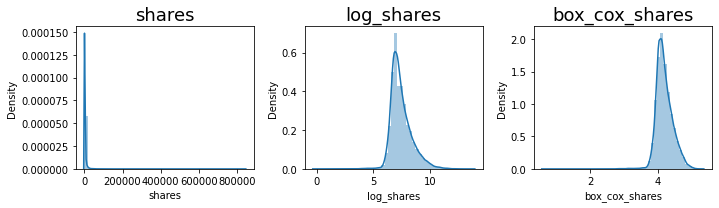

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
for i in range(3):
    col = df.columns[-3:][i]
    sns.distplot(df[col], ax = axs.flat[i])
    axs.flat[i].set_title(col, fontsize=18)
plt.tight_layout()
plt.savefig('shares EDA')

## Explore Numerical Features

In [10]:
# seperate categorical features and numerical features
df = df.drop(columns='url')
category_feature=[]
numerical_feature=[]
for col in df.columns:
    if df.groupby(col)[col].nunique().size==2:
        category_feature.append(col)
    else:
        numerical_feature.append(col)

In [11]:
def plotNumericalScatter(df, nGraphShown, nGraphPerRow):
    """plot original numerical features with scatter diagrams"""
    sub_df=df[numerical_feature[:-3]]
    shares = df['shares']
    nRow, nCol = sub_df.shape
    columnNames = numerical_feature
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = sub_df.iloc[:, i]
        plt.scatter(columnDf, shares, c='blue', marker='o')
 
        plt.ylabel('shares')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

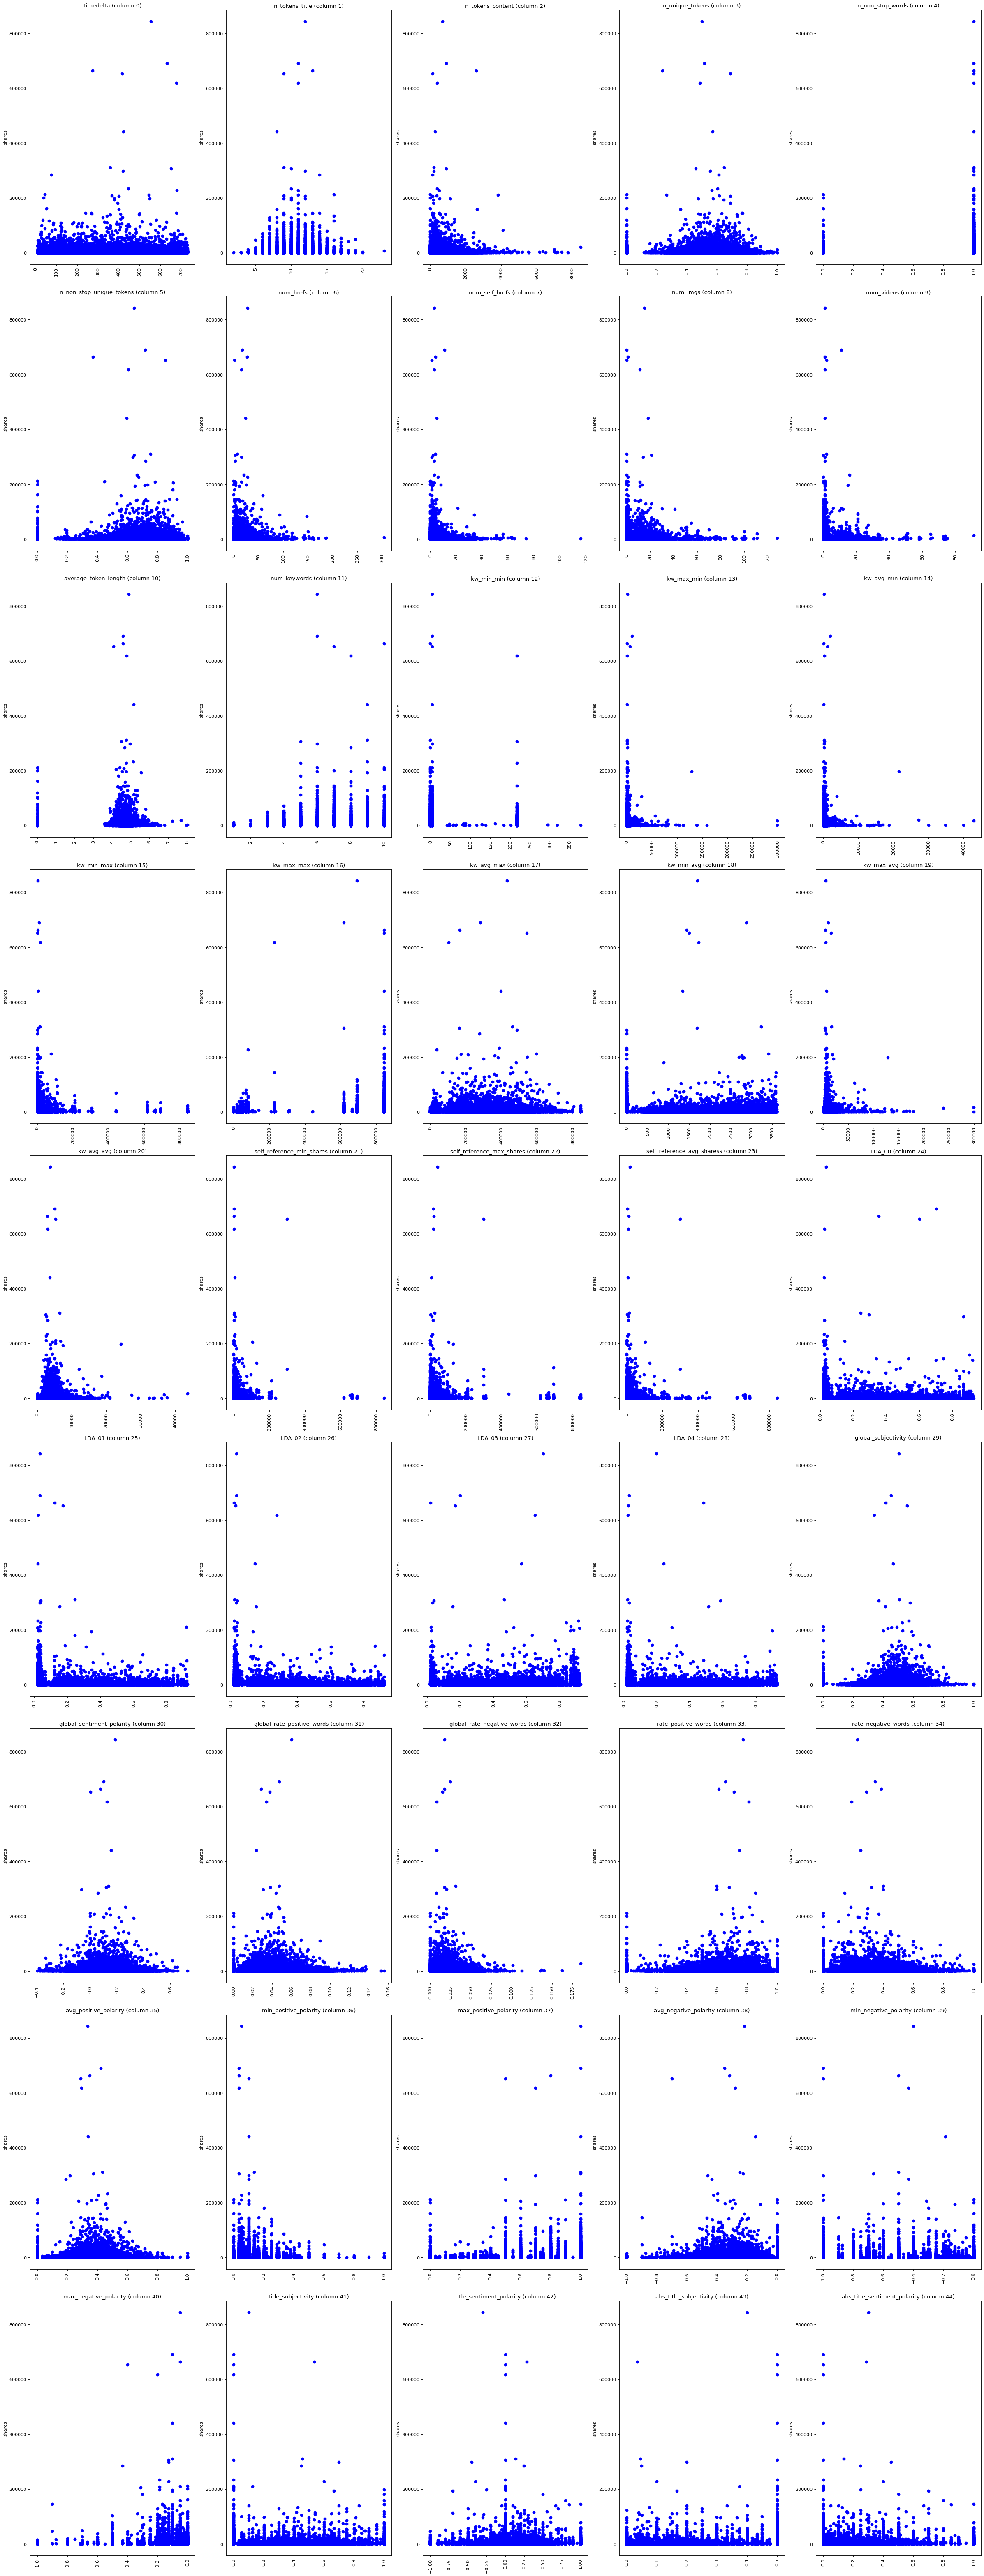

In [12]:
plotNumericalScatter(df, 60, 5)

In [13]:
def plotLogNumericalScatter(df, nGraphShown, nGraphPerRow):
    """plot numerical features (after log transformation) with scatter diagrams"""
    sub_df=df[numerical_feature[:-3]]
    shares = df['shares'].apply(lambda x: math.log(x,10))
    nRow, nCol = sub_df.shape
    columnNames = numerical_feature
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = sub_df.iloc[:, i]
        plt.scatter(columnDf, shares, c='blue', marker='o')
 
        plt.ylabel('shares')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

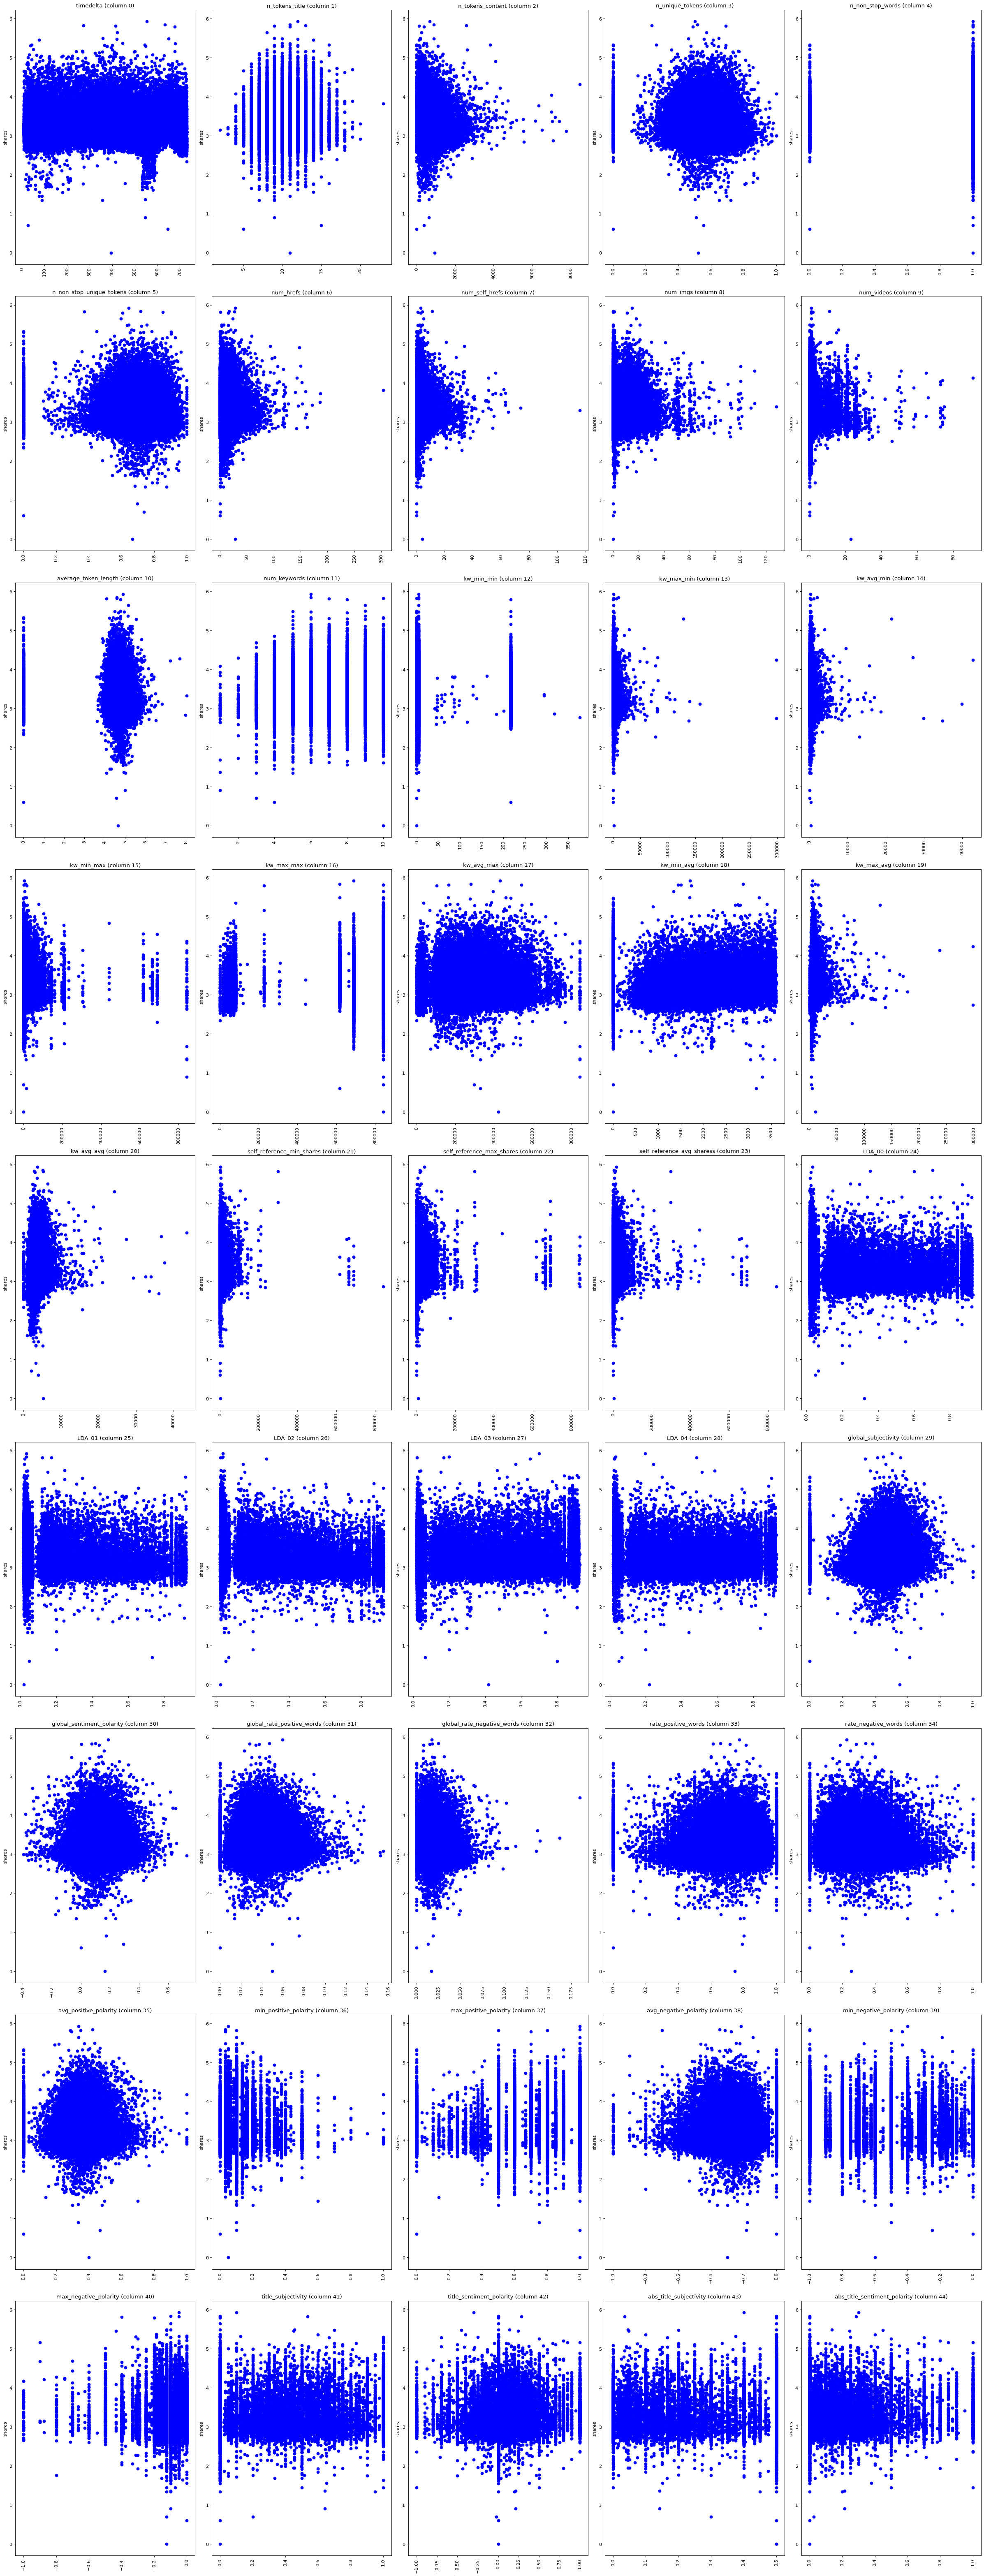

In [14]:
plotLogNumericalScatter(df,60,5)

# Explore Categorical Features

In [15]:
# seperate the target 'Share' into 4 categories
df['cat'] = '0'
df.loc[(df['shares']< 2350)&(df['shares']>=1065) ,['cat']] = '1'
df.loc[(df['shares'] <7550)&(df['shares']>=2350),['cat']] = '2'
df.loc[df['shares']>= 7550,['cat']] = '3'

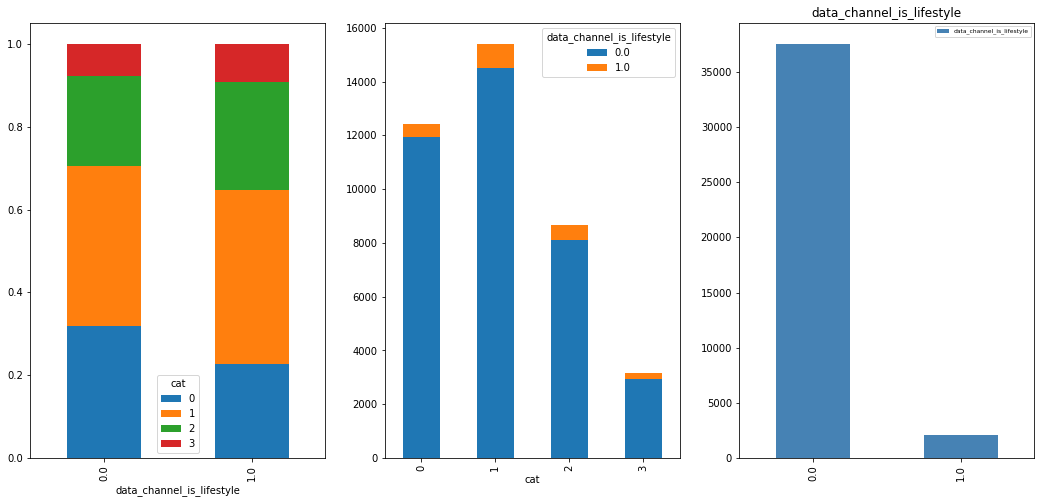

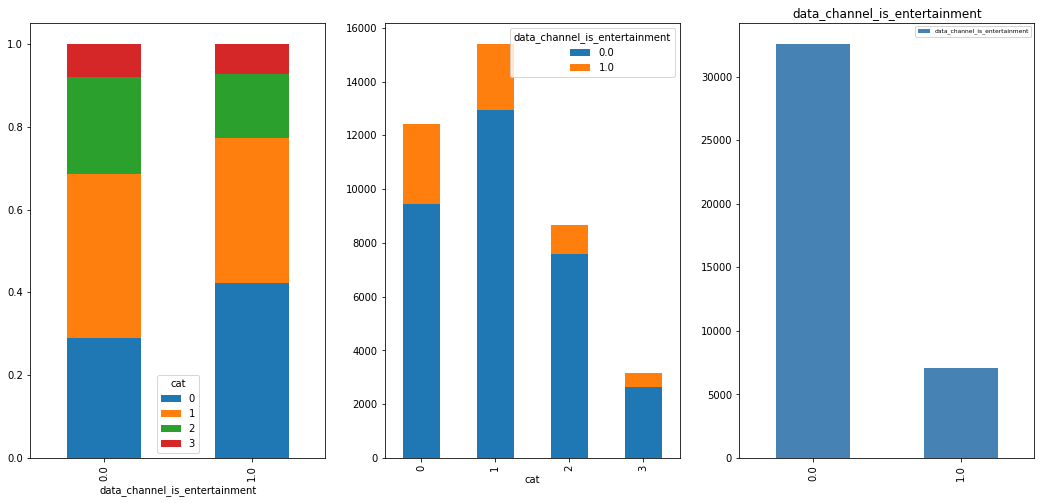

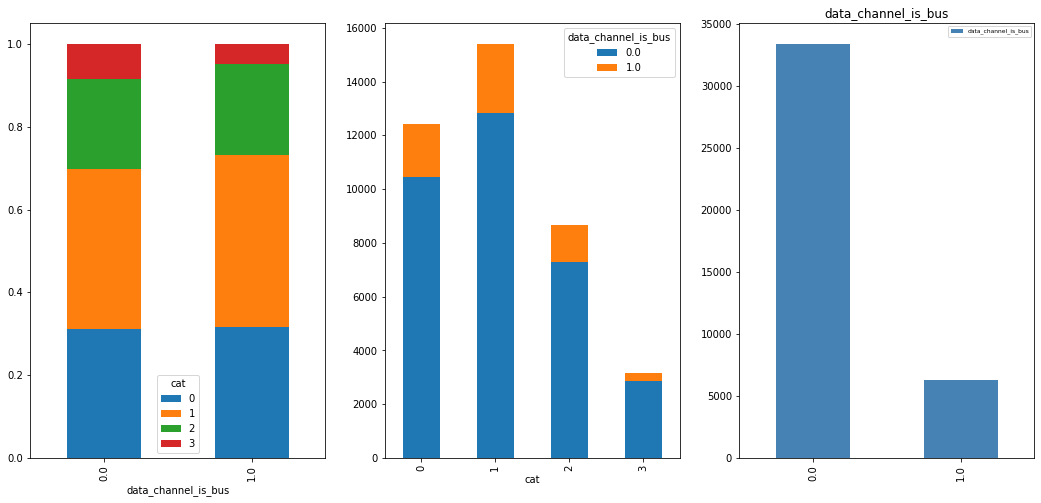

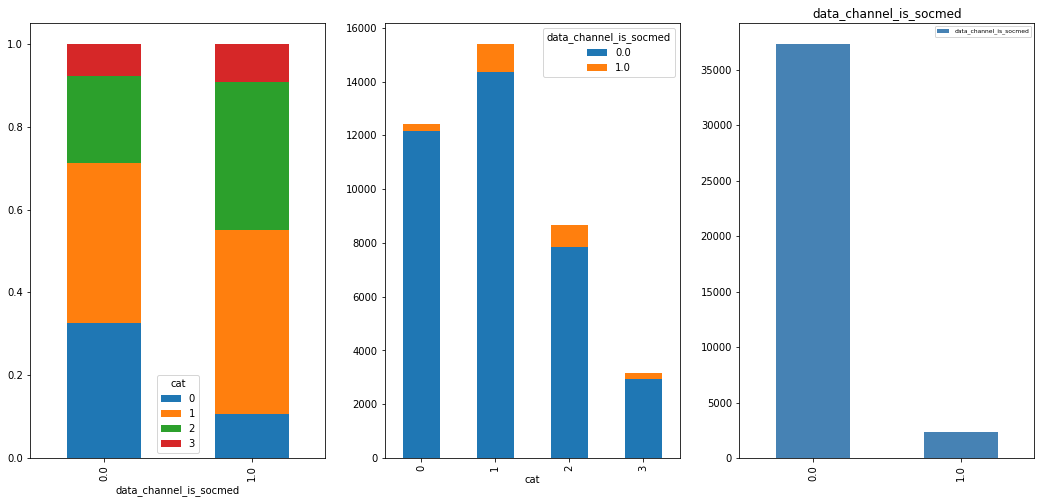

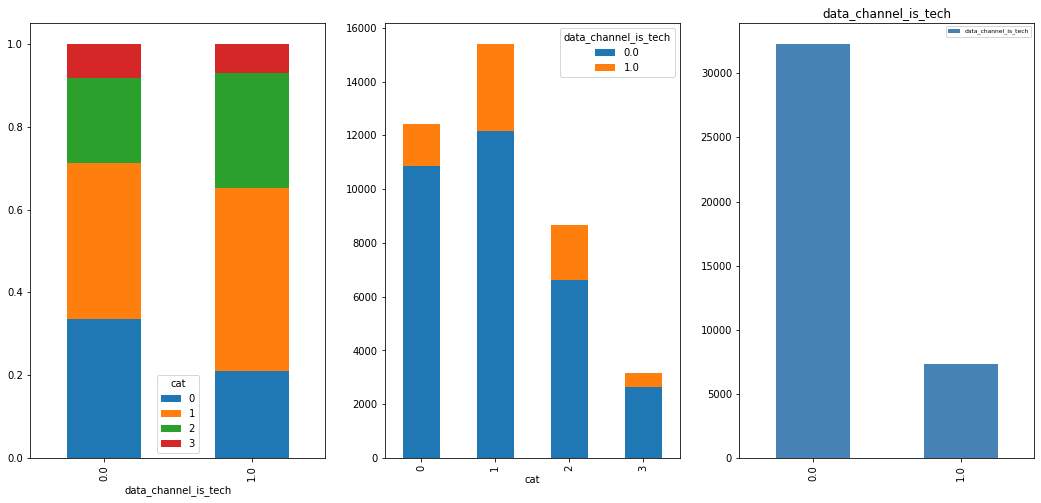

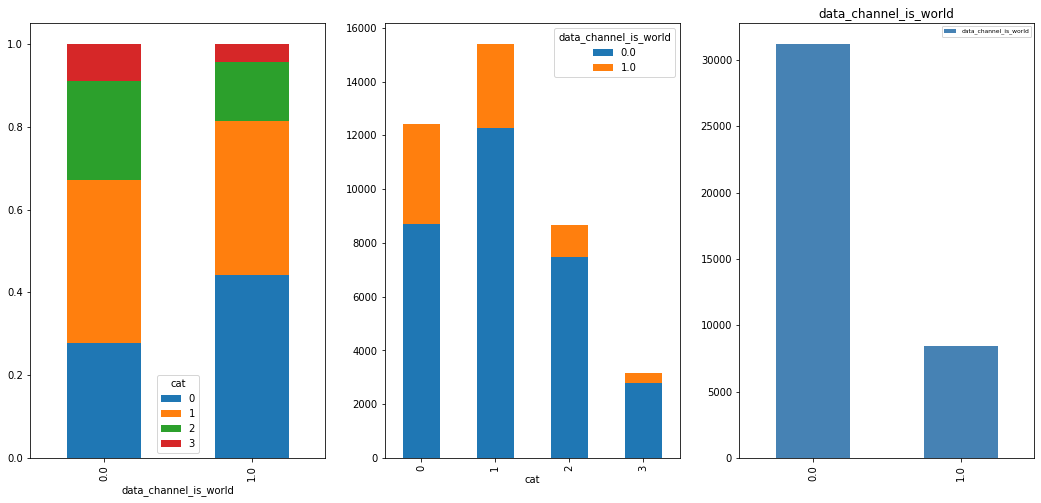

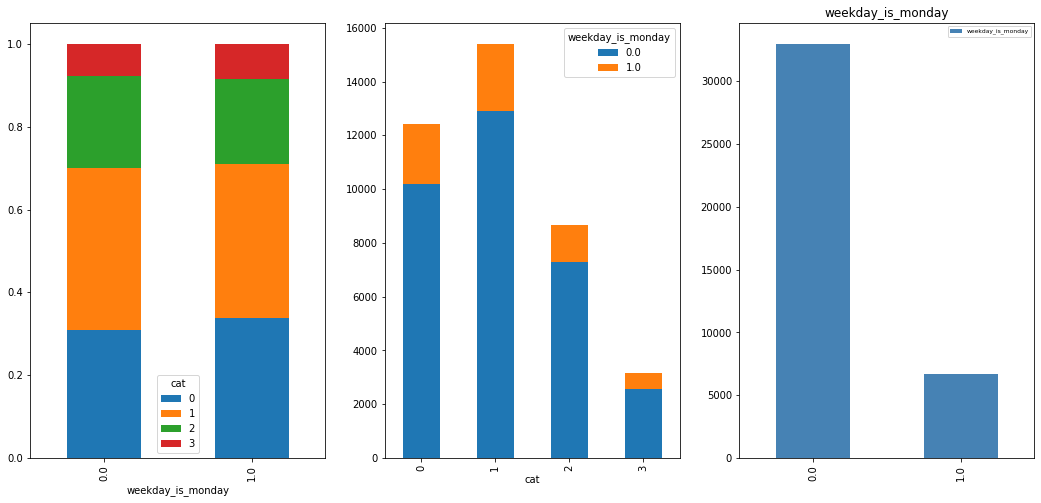

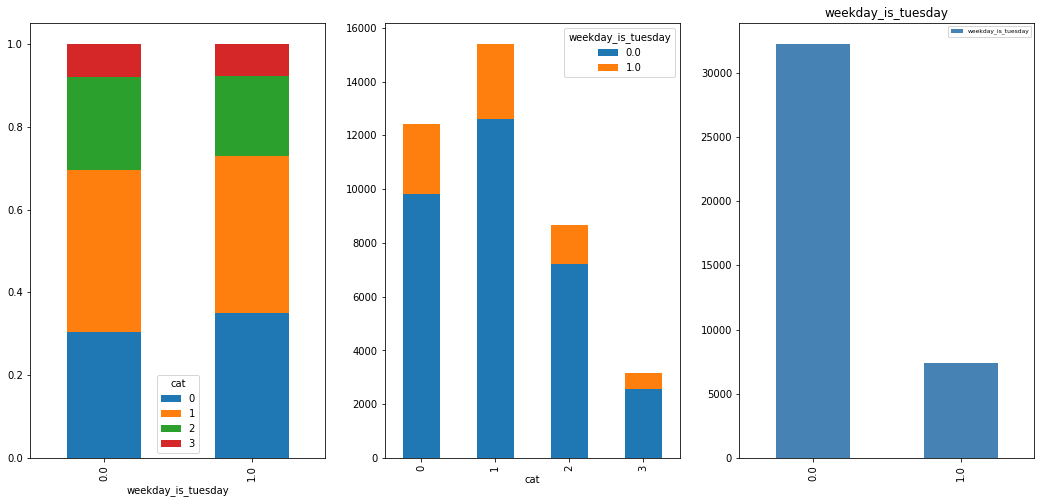

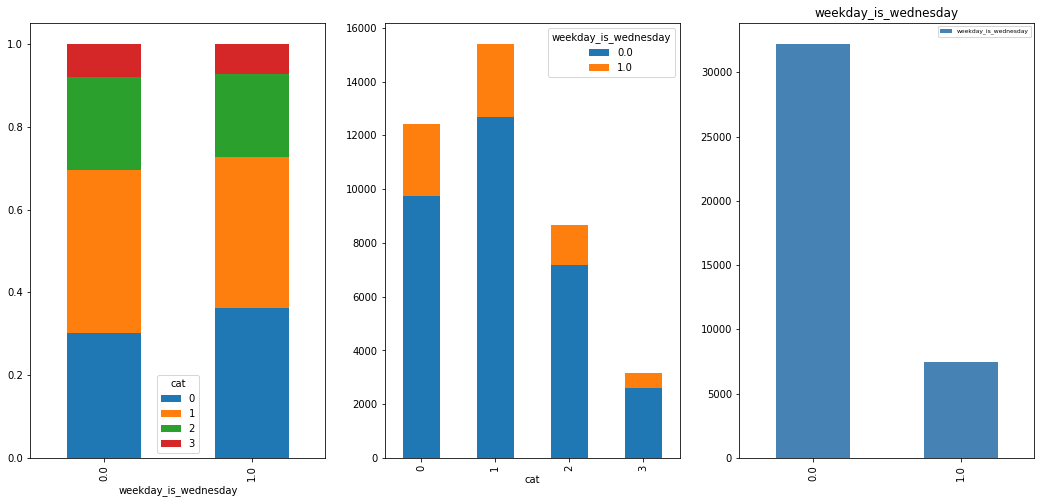

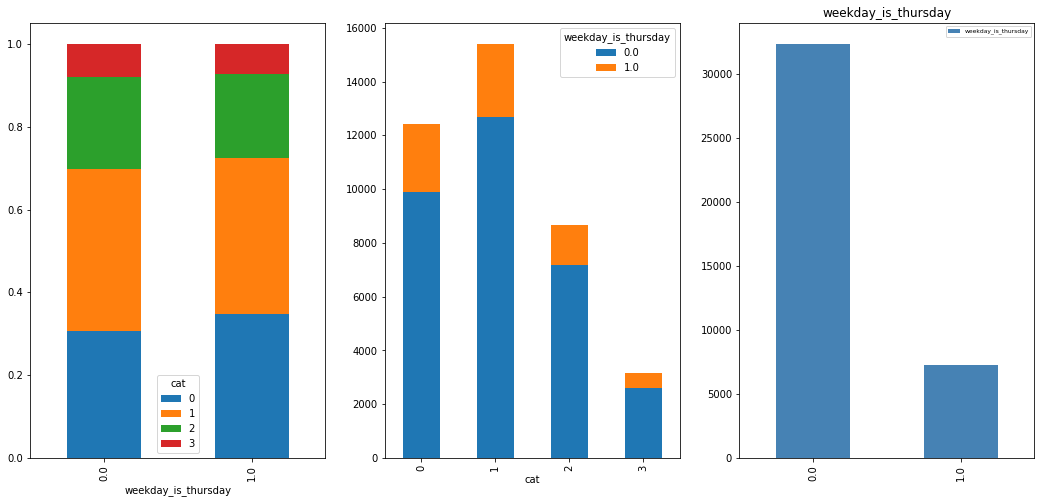

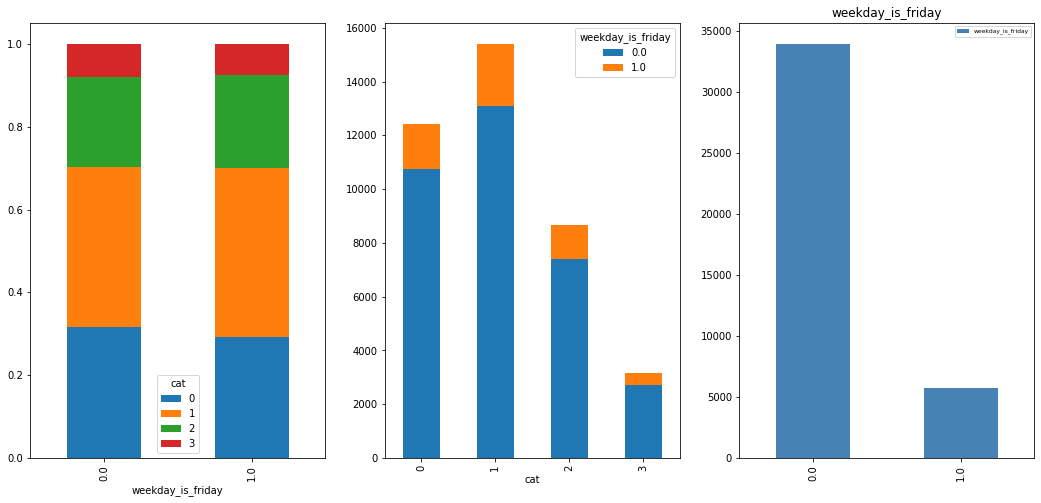

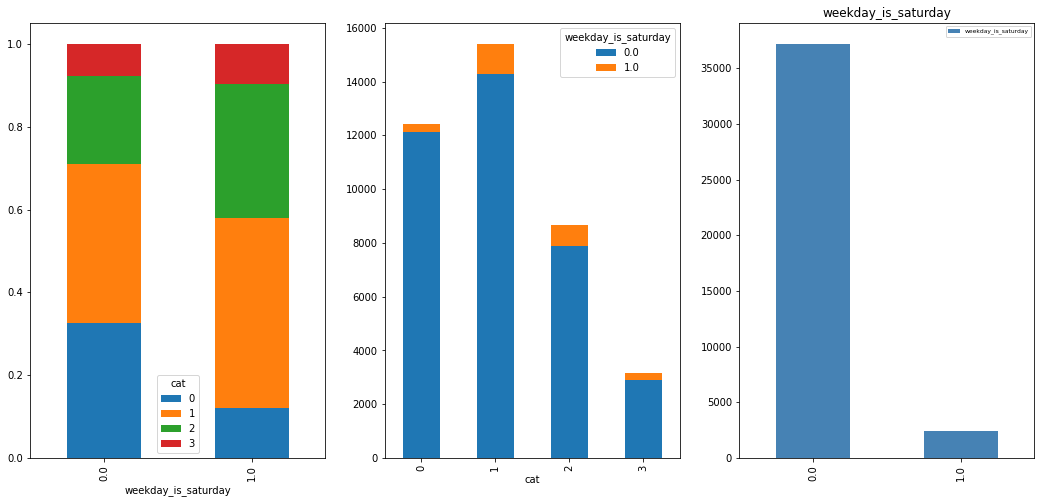

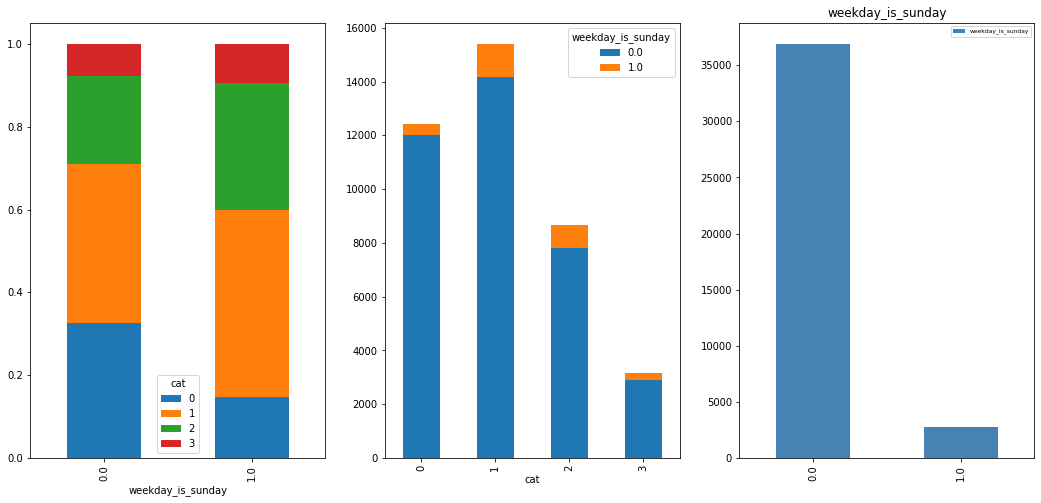

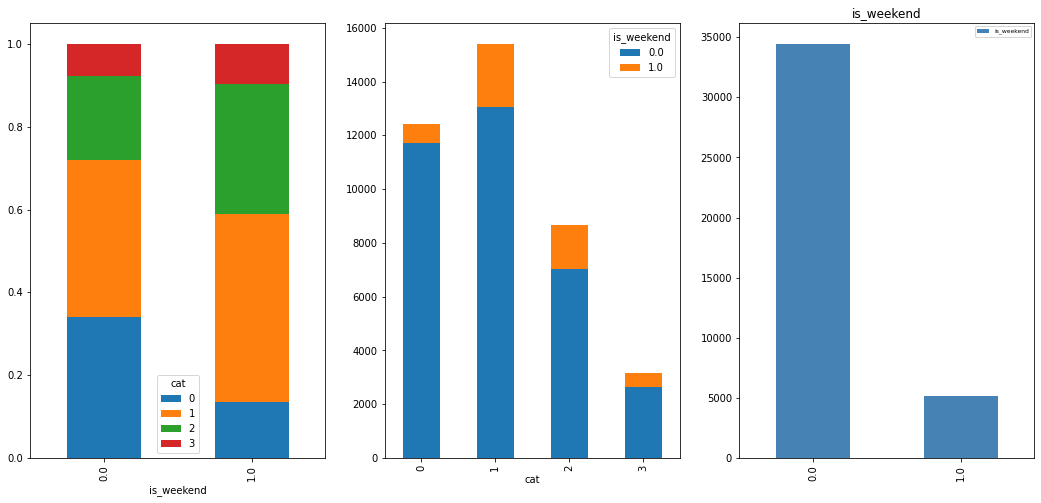

In [16]:
# plot the features with respect to the Share categories
for attr in category_feature:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,8))
  outcome_counts = df.groupby([attr, 'cat']).size().rename('count').reset_index()
  by_outcome = outcome_counts.pivot(columns='cat', values='count', index=attr)
  by_attr = outcome_counts.pivot(columns=attr, values='count', index='cat')
  # Plot the proportions
  by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
  by_attr.plot.bar(stacked=True, ax=ax2);
  # Plot the counts
  df[attr].value_counts().plot.bar(ax=ax3, legend=False,color='steelblue');
  plt.legend(fontsize=6)
  plt.title(attr);

## Explore Time Feaures 

In [17]:
day_list = list(df.columns[df.columns.str.startswith('weekday')])
day_list

['weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday']

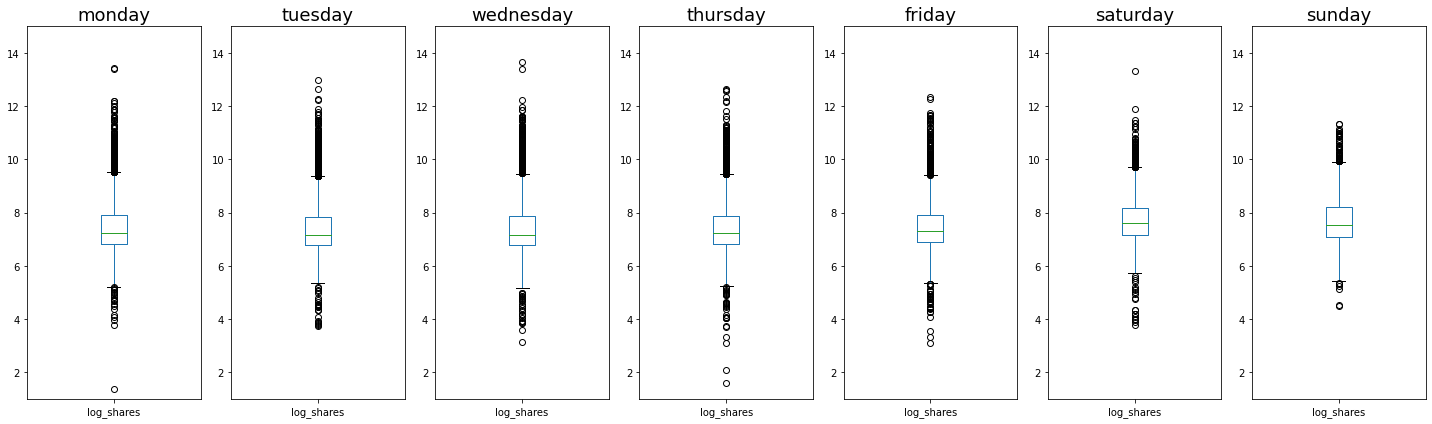

In [18]:
# box plots for weekday features
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 6))
for i in range(len(day_list)):
    df_i = df[df[day_list[i]]==1]
    df_i['log_shares'].plot(kind='box',ax=axs.flat[i])
    axs.flat[i].set_title(day_list[i][11:], fontsize=18)
    axs.flat[i].set_ylim([1, 15])
plt.tight_layout()
plt.savefig('day EDA')

## Explore Channel and Topic Features

In [19]:
# prepare lists of channel features and topic features
channel_list = list(df.columns[df.columns.str.contains('channel')])
topic_list = list(df.columns[df.columns.str.contains('LDA')])
print(channel_list)
print(topic_list)

['data_channel_is_lifestyle', 'data_channel_is_entertainment', 'data_channel_is_bus', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world']
['LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04']


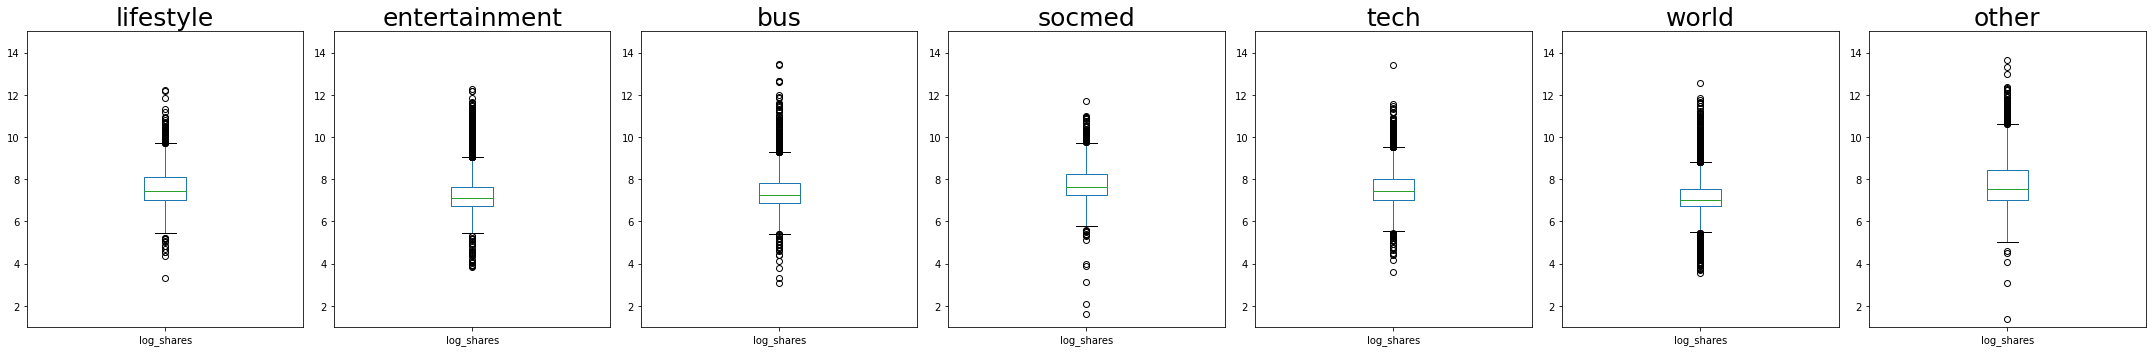

In [20]:
# box plots for channel features
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(30, 5))
for i in range(len(channel_list)):
    df_i = df[df[channel_list[i]]==1]
    df_i['log_shares'].plot(kind='box',ax=axs.flat[i])
    axs.flat[i].set_title(channel_list[i][16:], fontsize=25)
    axs.flat[i].set_ylim([1, 15])

df['temp'] = sum(df[channel_list[i]] for i in range(6))
df_other = df[df['temp']==0]
df = df.drop('temp', axis=1)
df_other['log_shares'].plot(kind='box',ax=axs.flat[6])
axs.flat[6].set_title('other', fontsize=25)
axs.flat[6].set_ylim([1, 15])

plt.tight_layout()
plt.savefig('channel EDA')

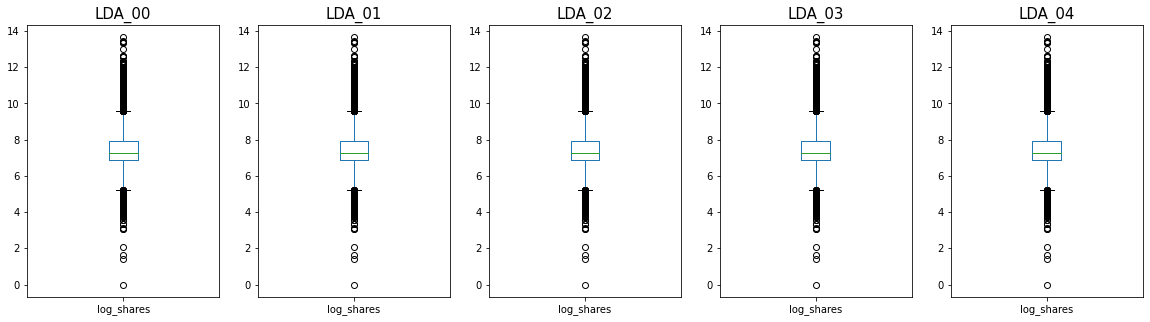

In [21]:
# box plots for topic features
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i in range(len(topic_list)):
    df['log_shares'].plot(kind='box',ax=axs.flat[i])
    axs.flat[i].set_title(topic_list[i], fontsize=15)
    
plt.savefig('LDA EDA')

## Explore LDA Features

In [22]:
df['LDA']= df[topic_list].idxmax(axis=1)

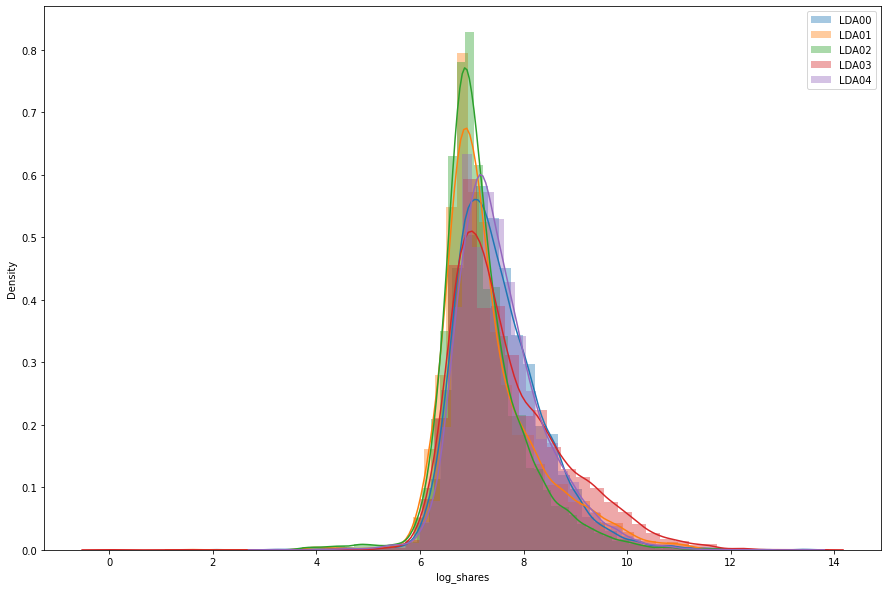

In [23]:
#plot distribution of different topics with respected to log_shares
plt.figure(figsize=(15,10))
sns.distplot(df[df.LDA=='LDA_00']['log_shares'], label='LDA00')
sns.distplot(df[df.LDA=='LDA_01']['log_shares'], label='LDA01')
sns.distplot(df[df.LDA=='LDA_02']['log_shares'], label='LDA02')
sns.distplot(df[df.LDA=='LDA_03']['log_shares'], label='LDA03')
sns.distplot(df[df.LDA=='LDA_04']['log_shares'], label='LDA04')
plt.legend()
plt.savefig('LDA EDA2')

plt.figure(figsize=(15,10))
sns.scatterplot(data=df, x="LDA_00", y="log_shares", alpha=0.1, label='LDA00' )
sns.scatterplot(data=df, x="LDA_01", y="log_shares", alpha=0.1, label='LDA01')
sns.scatterplot(data=df, x="LDA_02", y="log_shares", alpha=0.1, label='LDA02')
sns.scatterplot(data=df, x="LDA_03", y="log_shares", alpha=0.1, label='LDA03')
sns.scatterplot(data=df, x="LDA_04", y="log_shares", alpha=0.1, label='LDA04')
plt.legend()
plt.savefig()